In [1]:
#4-6, notebook to import NISAR frames and RGI data, find NISAR frames w/ glaciers of interest (10km2 or larger)

In [8]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube
from shapely import geometry
import fiona
import pandas as pd

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature


<AxesSubplot:>

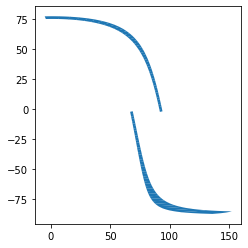

In [9]:
#reading in a kml for a single frame to see how it looks
#this is the kml file made from querying a spec path (98) in gdal cl
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
nisar_frame98 = gpd.read_file('/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/nisar_frames/T98A.kml', driver = 'KML')
nisar_frame98.plot()

In [10]:
def nisar_scenes_w_rgi_glaciers_from_path(rgi_path, nisar_df):
    '''this function takes a dataframe of rgi glaciers and a dataframe of nisar frames and 
    returns a dataframe that contains only the nisar frames containing rgi glaciers '''
    
    #read in rgi shp files from directory containing files for all rgi regions 
    rgi_ls = os.listdir(rgi_path)
    #make dict where each key is region name, each value is the geo dataframe w/ rgi glaciers for that region
    rgi_region_key_ls = []
    rgi_region_val_ls = []
    for element in range(len(rgi_ls)):
        region_name = rgi_ls[element][:-8]
        if rgi_ls[element][-4:] == '.shp':
            rgi_region_key_ls.append(region_name)
            rgi_gpdf = gpd.read_file(f'/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km/{rgi_ls[element]}')
            rgi_region_val_ls.append(rgi_gpdf)
    rgi_dict = dict(zip(rgi_region_key_ls, rgi_region_val_ls))

    #because read in rgi data for all glaciers larger than 1km2, make a new dict w/ same setup but only glaciers larger than 10km2
    rgi_10km_dict = {k:v.loc[v['Area'] >=10.] for (k,v) in rgi_dict.items()}
    #now, make dict into a single df for all regions
    rgi_df = pd.concat(list(rgi_10km_dict.values()), axis=0)

    
    #use spatial join to select nisar frames containing rgi glaciers 
    join_df = nisar_df.sjoin(rgi_df, how='inner')
    #make list of frame names (theres a row for every glacier so there will be repeat rows wrt nisar frame id)
    nisar_frames_ls = join_df['Description'].to_list()
    #find unique values in the list
    nisar_frames_uni = list(set(nisar_frames_ls))
    print(nisar_frames_uni)
    
    #now, want to go back to original nisar frame df and take only the rows with target glaciers
    nisar_df_sub = nisar_df[nisar_df['Name'].isin(nisar_frames_uni)]
    
    #plot to take a look
    fig, ax = plt.subplots()
    #plot selected nisar scenes
    nisar_df_sub.plot(ax=ax, color='blue')
    #plot all nisar scenes w/ low alpha
    nisar_df.plot(ax=ax, color='red', alpha=0.3)
    #plot glacier outlines
    rgi_df.plot(ax=ax, color='green')
    
    #return join_df
    return nisar_df_sub
    

In [14]:
rgi_path1 = '/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km'
nisar_path98 = '/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/nisar_frames/T98A.kml'

['L098_F015_AF', 'L098_F020_AF', 'L098_F043_AF', 'L098_F016_AF', 'L098_F018_AF', 'L098_F044_AF', 'L098_F019_AF', 'L098_F017_AF', 'L098_F023_AF']


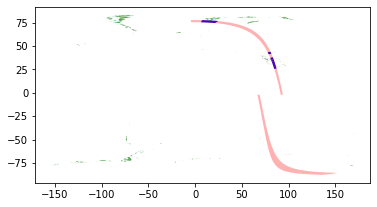

In [15]:
nisar_df98 = nisar_scenes_w_rgi_glaciers_from_path(rgi_path1, nisar_frame98)

In [16]:
nisar_df98

,Name,Description,geometry
14,L098_F015_AF,L098_F015_AF,"POLYGON ((87.10546 26.01420, 86.58286 25.88828..."
15,L098_F016_AF,L098_F016_AF,"POLYGON ((86.51128 28.00083, 85.97997 27.87250..."
16,L098_F017_AF,L098_F017_AF,"POLYGON ((85.89380 29.98624, 85.35286 29.85532..."
17,L098_F018_AF,L098_F018_AF,"POLYGON ((85.25042 31.97028, 84.69887 31.83657..."
18,L098_F019_AF,L098_F019_AF,"POLYGON ((84.57821 33.95280, 84.01499 33.81608..."
19,L098_F020_AF,L098_F020_AF,"POLYGON ((83.87378 35.93359, 83.29776 35.79363..."
22,L098_F023_AF,L098_F023_AF,"POLYGON ((81.52539 41.86333, 80.90324 41.71183..."
42,L098_F043_AF,L098_F043_AF,"POLYGON ((24.60155 76.58967, 23.82190 76.13354..."
43,L098_F044_AF,L098_F044_AF,"POLYGON ((17.01307 77.17338, 16.45766 76.69785..."
